<p align="center">
<img src='../documentation/images/logo.png' width="180px">
</p>

# Vertica ML Python Example

This notebook is an example on how to use the Vetica ML Python Library. It will use the Titanic dataset to introduce you the library. The purpose is to predict the passengers survival.

## Initialization

Let's create a connection and load the dataset.

In [1]:
from vertica_ml_python.utilities import vertica_cursor
from vertica_ml_python.learn.datasets import load_titanic
cur = vertica_cursor("VerticaDSN")
titanic = load_titanic(cur)
print(titanic)

,age,body,survived,ticket,home.dest,cabin,sex,pclass,embarked,parch,fare,name,boat,sibsp
0,2.000,None,0,113781,"Montreal, PQ / Chesterville, ON",C22 C26,female,1,S,2,151.55000,"Allison, Miss. Helen Loraine",None,1
1,30.000,135,0,113781,"Montreal, PQ / Chesterville, ON",C22 C26,male,1,S,2,151.55000,"Allison, Mr. Hudson Joshua Creighton",None,1
2,25.000,None,0,113781,"Montreal, PQ / Chesterville, ON",C22 C26,female,1,S,2,151.55000,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",None,1
3,39.000,None,0,112050,"Belfast, NI",A36,male,1,S,0,0.00000,"Andrews, Mr. Thomas Jr",None,0
4,71.000,22,0,PC 17609,"Montevideo, Uruguay",None,male,1,C,0,49.50420,"Artagaveytia, Mr. Ramon",None,0
,...,...,...,...,...,...,...,...,...,...,...,...,...,...


<object>  Name: titanic, Number of rows: 1234, Number of columns: 14


## Data Exploration and Preparation

Let's explore the data by displaying descriptive statistics of all the columns.

In [2]:
titanic.describe(method = "categorical")

,dtype,unique,count,top,top_percent
"""age""","numeric(6,3)",96,997,24.000,4.413
"""body""",int,118,118,1,0.847
"""survived""",int,2,1234,0,63.533
"""ticket""",varchar(36),887,1234,CA. 2343,0.81
"""home.dest""",varchar(100),359,706,"New York, NY",8.782
"""cabin""",varchar(30),182,286,C23 C25 C27,2.098
"""sex""",varchar(20),2,1234,male,65.964
"""pclass""",int,3,1234,3,53.728
"""embarked""",varchar(20),3,1232,S,70.86
"""parch""",int,8,1234,0,76.904


<object>

The column "body" is useless as it is only the ID of the passengers. Besides, it has too much missing values. 
The column "home.dest" will not influence the survival as it is from where the passengers embarked and where they are going to. We can have the same conclusion with "embarked" which is the port of embarkation. The column 'ticket' which is the ticket ID will also not give us information on the survival. Let's analyze the columns "name" and "cabin to see if we can extract some information. Let's first look at the passengers 'name'.

In [3]:
from vertica_ml_python.learn.preprocessing import CountVectorizer
CountVectorizer("name_voc", cur).fit("titanic", ["Name"]).to_vdf()

,token,df,cnt,rnk
0,mr,0.148163100524828421,734,1
1,miss,0.046023415421881308,228,2
2,mrs,0.037343560758982640,185,3
3,william,0.016148566814695196,80,4
4,john,0.013726281792490916,68,5
,...,...,...,...


<object>  Name: name_voc, Number of rows: 1841, Number of columns: 4

It is possible to extract from the 'name' the title of the passengers. Let's now look at the 'cabins'.

In [4]:
from vertica_ml_python.learn.preprocessing import CountVectorizer
CountVectorizer("cabin_voc", cur).fit("titanic", ["cabin"]).to_vdf()

,token,df,cnt,rnk
0,None,0.733746130030959752,948,1
1,f,0.006191950464396285,8,2
2,c27,0.004643962848297214,6,3
3,c25,0.004643962848297214,6,3
4,c23,0.004643962848297214,6,3
,...,...,...,...


<object>  Name: cabin_voc, Number of rows: 199, Number of columns: 4

We can extract the cabin position (the letter which reprent the position in the boat) and look at the number of occurences.

In [5]:
CountVectorizer("cabin_voc", cur).fit("titanic", ["cabin"]).to_vdf()["token"].str_slice(1, 1).groupby(
                columns = ["token"], expr = ["SUM(cnt)"]).head(30)

,token,SUM
0,None,948
1,a,20
2,b,92
3,c,113
4,d,47
5,e,43
6,f,19
7,g,9
8,t,1


<object>  Name: cabin_voc, Number of rows: 9, Number of columns: 2

The NULL values possibly represent passengers having no cabin (MNAR = Missing values not at random). The same for the column "boat" NULL values which represent passengers who bought the 'lifeboat' option. We can drop the useless columns and encode the others.

In [6]:
titanic.drop(["body", "home.dest", "embarked", "ticket"])

,age,survived,cabin,sex,pclass,parch,fare,name,boat,sibsp
0,2.000,0,C22 C26,female,1,2,151.55000,"Allison, Miss. Helen Loraine",None,1
1,30.000,0,C22 C26,male,1,2,151.55000,"Allison, Mr. Hudson Joshua Creighton",None,1
2,25.000,0,C22 C26,female,1,2,151.55000,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",None,1
3,39.000,0,A36,male,1,0,0.00000,"Andrews, Mr. Thomas Jr",None,0
4,71.000,0,None,male,1,0,49.50420,"Artagaveytia, Mr. Ramon",None,0
,...,...,...,...,...,...,...,...,...,...


<object>  Name: titanic, Number of rows: 1234, Number of columns: 10

In [7]:
titanic["cabin"].str_slice(1, 1)["name"].str_extract(' ([A-Za-z]+)\.')["boat"].fillna(
        method = "0ifnull")["cabin"].fillna("No Cabin")

795 elements were filled
948 elements were filled


,age,survived,cabin,sex,pclass,parch,fare,name,boat,sibsp
0,2.000,0,C,female,1,2,151.55000,Miss.,0,1
1,30.000,0,C,male,1,2,151.55000,Mr.,0,1
2,25.000,0,C,female,1,2,151.55000,Mrs.,0,1
3,39.000,0,A,male,1,0,0.00000,Mr.,0,0
4,71.000,0,No Cabin,male,1,0,49.50420,Mr.,0,0
,...,...,...,...,...,...,...,...,...,...


<object>  Name: titanic, Number of rows: 1234, Number of columns: 10

We can notice that our assumptions about the cabin is wrong as passengers in first class must have a cabin. This column has missing values at random (MAR) and too much. We can drop it.

In [8]:
titanic["cabin"].drop()

,age,survived,sex,pclass,parch,fare,name,boat,sibsp
0,2.000,0,female,1,2,151.55000,Miss.,0,1
1,30.000,0,male,1,2,151.55000,Mr.,0,1
2,25.000,0,female,1,2,151.55000,Mrs.,0,1
3,39.000,0,male,1,0,0.00000,Mr.,0,0
4,71.000,0,male,1,0,49.50420,Mr.,0,0
,...,...,...,...,...,...,...,...,...


<object>  Name: titanic, Number of rows: 1234, Number of columns: 9

Let's look at descriptive statistics of the entire Virtual Dataframe.

In [9]:
titanic.statistics()

,"""age""","""survived""","""pclass""","""parch""","""fare""","""boat""","""sibsp"""
count,997.0,1234.0,1234.0,1234.0,1233.0,1234.0,1234.0
avg,30.1524573721163,0.364667747163695,2.28444084278768,0.378444084278768,33.9637936739659,0.355753646677472,0.504051863857374
stddev,14.4353046299159,0.481532018641288,0.842485636190292,0.868604707790392,52.6460729831293,0.478935143777661,1.04111727241629
min,0.33,0.0,1.0,0.0,0.0,0.0,0.0
10%,14.5,0.0,1.0,0.0,7.5892,0.0,0.0
25%,21.0,0.0,1.0,0.0,7.8958,0.0,0.0
median,28.0,0.0,3.0,0.0,14.4542,0.0,0.0
75%,39.0,1.0,3.0,0.0,31.3875,1.0,1.0
90%,50.0,1.0,3.0,1.0,79.13,1.0,1.0
max,80.0,1.0,3.0,9.0,512.3292,1.0,8.0


<object>

We can have with this method many relevant information. We can notice for example that the 'age' of the passengers follows more or less a normal distribution (kurtosis and skewness around 0).

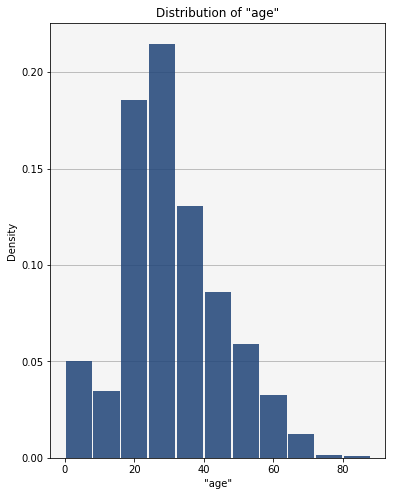

In [11]:
x = titanic["age"].hist()

The column 'fare' has many outliers (512.33 which is the maximum is much greater than 79.13 which is the 9th decile). Most of the passengers traveled in 3rd class (median of pclass = 3) and much more...

'sibsp' represents the number of siblings and parch the number of parents and children, it can be relevant to build a new feature 'family_size'.

In [12]:
titanic.eval("family_size", "parch + sibsp + 1")

The new vColumn "family_size" was added to the vDataframe.


,age,survived,sex,pclass,parch,fare,name,boat,sibsp,family_size
0,2.000,0,female,1,2,151.55000,Miss.,0,1,4
1,30.000,0,male,1,2,151.55000,Mr.,0,1,4
2,25.000,0,female,1,2,151.55000,Mrs.,0,1,4
3,39.000,0,male,1,0,0.00000,Mr.,0,0,1
4,71.000,0,male,1,0,49.50420,Mr.,0,0,1
,...,...,...,...,...,...,...,...,...,...


<object>  Name: titanic, Number of rows: 1234, Number of columns: 10

Let's deal with the outliers. There are many methods to find them (LocalOutlier Factors, DBSCAN, KMeans...) but we will just winsorize the 'fare' distribution which is the main subject to this anomaly (some passengers could have paid a very expensive fare but outliers could destroy our model prediction). 

In [13]:
titanic["fare"].fill_outliers(method = "winsorize", alpha = 0.03)

,age,survived,sex,pclass,parch,fare,name,boat,sibsp,family_size
0,2.000,0,female,1,2,151.5500000000000,Miss.,0,1,4
1,30.000,0,male,1,2,151.5500000000000,Mr.,0,1,4
2,25.000,0,female,1,2,151.5500000000000,Mrs.,0,1,4
3,39.000,0,male,1,0,0E-13,Mr.,0,0,1
4,71.000,0,male,1,0,49.5042000000000,Mr.,0,0,1
,...,...,...,...,...,...,...,...,...,...


<object>  Name: titanic, Number of rows: 1234, Number of columns: 10

Let's encode the column 'sex' to be able to use it with numerical methods. 

In [14]:
titanic["sex"].label_encode()

,age,survived,sex,pclass,parch,fare,name,boat,sibsp,family_size
0,2.000,0,0,1,2,151.5500000000000,Miss.,0,1,4
1,30.000,0,1,1,2,151.5500000000000,Mr.,0,1,4
2,25.000,0,0,1,2,151.5500000000000,Mrs.,0,1,4
3,39.000,0,1,1,0,0E-13,Mr.,0,0,1
4,71.000,0,1,1,0,49.5042000000000,Mr.,0,0,1
,...,...,...,...,...,...,...,...,...,...


<object>  Name: titanic, Number of rows: 1234, Number of columns: 10

The column 'age' has too many missing values and we need to impute them. Let's impute them by the average of passengers having the same 'pclass' and the same 'sex'.

In [15]:
titanic["age"].fillna(method = "mean", by = ["pclass", "sex"])

237 elements were filled


,age,survived,sex,pclass,parch,fare,name,boat,sibsp,family_size
0,36.0,1,0,1,0,135.6333000000000,Miss.,1,0,1
1,31.0,1,0,1,0,134.5000000000000,Miss.,1,0,1
2,21.0,1,0,1,0,26.5500000000000,Miss.,1,0,1
3,50.0,1,0,1,1,211.5000000000000,Mrs.,1,1,3
4,45.0,1,0,1,1,164.8667000000000,Mrs.,1,1,3
,...,...,...,...,...,...,...,...,...,...


<object>  Name: titanic, Number of rows: 1234, Number of columns: 10

We can draw the correlation matrix to see different information we could get.

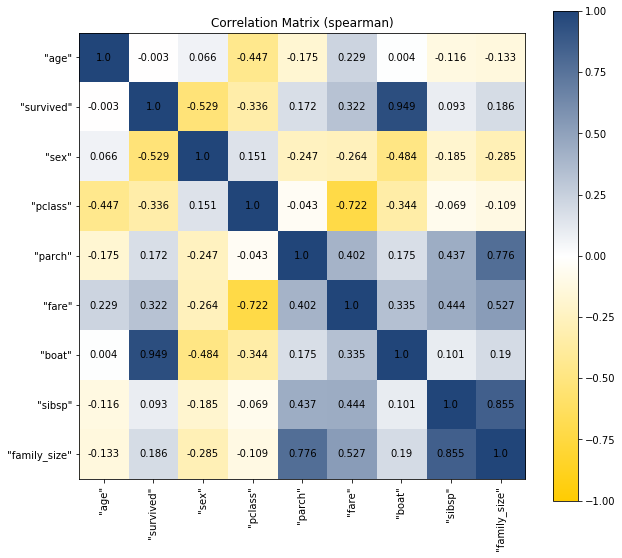

,"""age""","""survived""","""sex""","""pclass""","""parch""","""fare""","""boat""","""sibsp""","""family_size"""
"""age""",1,-0.003,0.066,-0.447,-0.175,0.229,0.004,-0.116,-0.133
"""survived""",-0.003,1,-0.529,-0.336,0.172,0.322,0.949,0.093,0.186
"""sex""",0.066,-0.529,1,0.151,-0.247,-0.264,-0.484,-0.185,-0.285
"""pclass""",-0.447,-0.336,0.151,1,-0.043,-0.722,-0.344,-0.069,-0.109
"""parch""",-0.175,0.172,-0.247,-0.043,1,0.402,0.175,0.437,0.776
"""fare""",0.229,0.322,-0.264,-0.722,0.402,1,0.335,0.444,0.527
"""boat""",0.004,0.949,-0.484,-0.344,0.175,0.335,1,0.101,0.19
"""sibsp""",-0.116,0.093,-0.185,-0.069,0.437,0.444,0.101,1,0.855
"""family_size""",-0.133,0.186,-0.285,-0.109,0.776,0.527,0.19,0.855,1


<object>

In [16]:
titanic.corr(method = "spearman")

The fare is very correlated to the family size. It is normal as the bigger the family is, the greater the number of tickets they have to buy will be (so the fare as well). The survival is very correlated to the 'boat'. In case of linear model we will never be able to predict the survival of the passenger having no life boat. To be able to create a real predictive model, we must split the study into 2 use cases: 
<ul>
    <li>Passengers having no lifeboat</li>
    <li>Passengers having a lifeboat</li>
</ul>
We did a lot of operations to clean this table and nothing was saved in the DB ! We can look at the Virtual Dataframe relation to be sure.

In [17]:
print(titanic.current_relation())


  (SELECT COALESCE("age", AVG("age") OVER (PARTITION BY pclass, sex)) AS "age",
          "survived" AS "survived",
          DECODE("sex", 'female', 0, 'male', 1, 2) AS "sex",
          "pclass" AS "pclass",
          "parch" AS "parch",
          (CASE
               WHEN "fare" < -176.6204982585513 THEN -176.6204982585513
               WHEN "fare" > 244.5480856064831 THEN 244.5480856064831
               ELSE "fare"
           END) AS "fare",
          REGEXP_SUBSTR("name", ' ([A-Za-z]+)\.') AS "name",
          DECODE("boat", NULL, 0, 1) AS "boat",
          "sibsp" AS "sibsp",
          parch + sibsp + 1 AS "family_size"
   FROM
     (SELECT "age" AS "age",
             "survived" AS "survived",
             "sex" AS "sex",
             "pclass" AS "pclass",
             "parch" AS "parch",
             "fare" AS "fare",
             "name" AS "name",
             "boat" AS "boat",
             "sibsp" AS "sibsp",
             0 AS "family_size"
      FROM "public"."titanic") t1

Let see what's happening when we aggregate and turn on the SQL.

In [18]:
titanic.sql_on_off().avg()

,avg
"""age""",29.717623352014
"""survived""",0.364667747163695
"""sex""",0.659643435980551
"""pclass""",2.28444084278768
"""parch""",0.378444084278768
"""fare""",32.9113074018842
"""boat""",0.355753646677472
"""sibsp""",0.504051863857374
"""family_size""",1.88249594813614


<object>

VERTICA ML Python will do SQL generation during the entire process and keep in mind all the users modifications.

In [19]:
titanic.sql_on_off().info()

The vDataframe was modified many times: 
 * {Fri Mar 20 20:52:40 2020} [Drop]: vColumn '"body"' was deleted from the vDataframe.
 * {Fri Mar 20 20:52:40 2020} [Drop]: vColumn '"home.dest"' was deleted from the vDataframe.
 * {Fri Mar 20 20:52:40 2020} [Drop]: vColumn '"embarked"' was deleted from the vDataframe.
 * {Fri Mar 20 20:52:40 2020} [Drop]: vColumn '"ticket"' was deleted from the vDataframe.
 * {Fri Mar 20 20:52:40 2020} [SUBSTR(, 1, 1)]: The vColumn 'cabin' was transformed with the func 'x -> SUBSTR(x, 1, 1)'.
 * {Fri Mar 20 20:52:40 2020} [REGEXP_SUBSTR(, ' ([A-Za-z]+)\.')]: The vColumn 'name' was transformed with the func 'x -> REGEXP_SUBSTR(x, ' ([A-Za-z]+)\.')'.
 * {Fri Mar 20 20:52:40 2020} [Fillna]: 795 missing values of the vColumn '"boat"' were filled.
 * {Fri Mar 20 20:52:40 2020} [Fillna]: 948 missing values of the vColumn '"cabin"' were filled.
 * {Fri Mar 20 20:52:41 2020} [Drop]: vColumn '"cabin"' was deleted from the vDataframe.
 * {Fri Mar 20 20:52:47 2020} [Ev

,age,survived,sex,pclass,parch,fare,name,boat,sibsp,family_size
0,36.0,1,0,1,0,135.6333000000000,Miss.,1,0,1
1,31.0,1,0,1,0,134.5000000000000,Miss.,1,0,1
2,21.0,1,0,1,0,26.5500000000000,Miss.,1,0,1
3,50.0,1,0,1,1,211.5000000000000,Mrs.,1,1,3
4,45.0,1,0,1,1,164.8667000000000,Mrs.,1,1,3
,...,...,...,...,...,...,...,...,...,...


<object>  Name: titanic, Number of rows: 1234, Number of columns: 10

You already love the Virtual Dataframe, do you? &#128540;

If you want to share the object with a member of the team, you can use the following method.

In [20]:
x = titanic.to_vdf("titanic")

We created a .vdf file which can be read with the 'read_vdf' function:

In [21]:
from vertica_ml_python.utilities import read_vdf
titanic2 = read_vdf("titanic.vdf", cur)
print(titanic2)

,age,survived,sex,pclass,parch,fare,name,boat,sibsp,family_size
0,36.0,1,0,1,0,135.6333000000000,Miss.,1,0,1
1,31.0,1,0,1,0,134.5000000000000,Miss.,1,0,1
2,21.0,1,0,1,0,26.5500000000000,Miss.,1,0,1
3,50.0,1,0,1,1,211.5000000000000,Mrs.,1,1,3
4,45.0,1,0,1,1,164.8667000000000,Mrs.,1,1,3
,...,...,...,...,...,...,...,...,...,...


<object>  Name: titanic, Number of rows: 1234, Number of columns: 10


Let's now save the vDataframe in the Database to fulfill the next step: Data Modelling.

In [22]:
from vertica_ml_python.utilities import drop_view
drop_view("titanic_boat", cur)
drop_view("titanic_not_boat", cur)
x = titanic.save().filter("boat = 1").to_db("titanic_boat").load().filter("boat = 0").to_db("titanic_not_boat")

The view titanic_boat was successfully dropped.
The view titanic_not_boat was successfully dropped.
795 elements were filtered
439 elements were filtered


## Machine Learning

### Passengers with a lifeboat


First let's look at the number of survivors in this dataset.

In [23]:
from vertica_ml_python import vDataframe
titanic_boat = vDataframe("titanic_boat", cur)
titanic_boat["survived"].describe()

,value
name,"""survived"""
dtype,int
unique,2
1,430
0,9


<object>

We only have 9 death. Let's try to understand why these passengers died.

In [24]:
titanic_boat.filter("survived = 0").head(10)

430 elements were filtered


,age,survived,family_size,sex,pclass,parch,fare,name,boat,sibsp
0,40.9822068965517,0,1,1,1,0,30.6958000000000,Mr.,1,0
1,36.0,0,1,1,1,0,75.2417000000000,Mr.,1,0
2,34.0,0,2,1,2,0,21.0000000000000,Mr.,1,1
3,30.0,0,2,0,3,0,15.5500000000000,Mrs.,1,1
4,27.0,0,2,1,3,0,14.4542000000000,Mr.,1,1
5,36.0,0,2,1,3,0,15.5500000000000,Mr.,1,1
6,26.2142058823529,0,1,1,3,0,7.2500000000000,Mr.,1,0
7,25.0,0,1,1,3,0,7.2500000000000,Mr.,1,0
8,32.0,0,2,1,3,0,15.8500000000000,Mr.,1,1


<object>  Name: titanic_boat, Number of rows: 9, Number of columns: 10

These passengers have no reason to die except the ones in third class. Building a model for this part of the data is useless.

### Passengers without a lifeboat

Let's now look at passengers without a lifeboat. 

In [25]:
from vertica_ml_python import vDataframe
titanic_boat = vDataframe("titanic_not_boat", cur)
titanic_boat["survived"].describe()

,value
name,"""survived"""
dtype,int
unique,2
0,775
1,20


<object>

Only 20 survived. Let's look why.

In [26]:
titanic_boat.filter("survived = 1").head(20)

775 elements were filtered


,age,survived,family_size,sex,pclass,parch,fare,name,boat,sibsp
0,58.0,1,1,0,1,0,146.5208000000000,Miss.,0,0
1,28.0,1,1,0,2,0,12.6500000000000,Mrs.,0,0
2,30.0,1,4,0,2,0,21.0000000000000,Mrs.,0,3
3,14.0,1,2,0,2,0,30.0708000000000,Mrs.,0,1
4,42.0,1,2,0,2,0,26.0000000000000,Mrs.,0,1
5,17.0,1,1,0,2,0,10.5000000000000,Miss.,0,0
6,34.0,1,2,0,2,1,23.0000000000000,Mrs.,0,0
7,18.0,1,2,0,2,1,23.0000000000000,Miss.,0,0
8,42.0,1,1,0,2,0,13.0000000000000,Mrs.,0,0
9,15.0,1,2,0,3,0,14.4542000000000,Mrs.,0,1


<object>  Name: titanic_not_boat, Number of rows: 20, Number of columns: 10

They are mostly women. The famous quotation "Women and children first" is then right. Let's build a model to get more insights. As predictors, we have one categorical columns. Besides, we have correlated features as predictors. It is preferable to work with a non-linear classifier which can handle that. Random Forest seems to be perfect for the study. Let's evaluate it with a Cross Validation.

In [27]:
from vertica_ml_python.learn.ensemble import RandomForestClassifier
from vertica_ml_python.learn.model_selection import cross_validate
from vertica_ml_python.utilities import drop_model

predictors = titanic.get_columns()
predictors.remove('"survived"')
response = "survived"
relation = "titanic_not_boat"
drop_model("rf_titanic", cur)
model = RandomForestClassifier("rf_titanic", cur, n_estimators = 40, max_depth = 4)
cross_validate(model, relation, predictors, response)

The model rf_titanic was successfully dropped.


,auc,prc_auc,accuracy,log_loss,precision,recall,f1-score,mcc,informedness,markedness,csi
1-fold,0.9141509433962265,0.15095036150132002,0.977859778597786,0.0328862549064335,0.0,0,0.0,0,-0.022140221402214055,0.0,0.0
2-fold,0.9512735326688813,0.21625700785364654,0.973584905660377,0.032638963467968,0.0,0,0.0,0,-0.026415094339622636,0.0,0.0
3-fold,0.9376778599886167,0.22072854394282942,0.972868217054264,0.0358277656426874,0.0,0,0.0,0,-0.027131782945736482,0.0,0.0
avg,0.934367445351,0.195978637766,0.974770967104,0.0337843280057,0.0,0.0,0.0,0.0,-0.0252290328959,0.0,0.0
std,0.0153349446772,0.0318920879035,0.00220363003126,0.00144845119492,0.0,0.0,0.0,0.0,0.00220363003126,0.0,0.0


<object>

As the dataset is unbalanced, the AUC is a good way to evaluate it. <br>
The model is very good with an average greater than 0.9 ! <br>
We can now build a model with the entire dataset.

In [28]:
model.fit(relation, predictors, response)



call_string
SELECT rf_classifier('public.rf_titanic', 'titanic_not_boat', '"survived"', '"age", "sex", "pclass", "parch", "fare", "name", "boat", "sibsp", "family_size"' USING PARAMETERS exclude_columns='', ntree=40, mtry=4, sampling_size=0.632, max_depth=4, max_breadth=1000000000, min_leaf_size=1, min_info_gain=0, nbins=32);

details
 predictor |      type      
-----------+----------------
    age    |float or numeric
    sex    |      int       
  pclass   |      int       
   parch   |      int       
   fare    |float or numeric
   name    |char or varchar 
   boat    |      int       
   sibsp   |      int       
family_size|      int       


Additional Info
       Name       |Value
------------------+-----
    tree_count    | 40  
rejected_row_count|  1  
accepted_row_count| 794 

Let's look at the features importance.

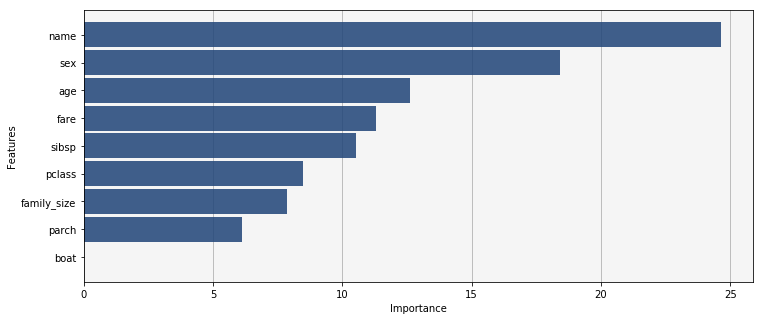

,importance
name,24.65
sex,18.43
age,12.6
fare,11.32
sibsp,10.54
pclass,8.48
family_size,7.86
parch,6.11
boat,0.0


<object>

In [29]:
model.features_importance()

As expected, the title and the sex are the most important predictors.

## Conclusion

We have solved this use-case in a pandas-like way but we never loaded the data in memory. This example showed an overview of the library. You can now start your own project by looking at the documentation first &#128521;